In [1]:
import tensorflow as tf
import os, re, pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
arabic_files = os.listdir("./Corpus/")
arabic_files

['Economy', 'International news', 'Local News', 'Sports']

In [3]:
economy_files = os.listdir("./Corpus/Economy")
economy_text = [pd.read_csv(os.path.join("./Corpus/Economy", file), names=["Text"]) for file in economy_files]
print("Number of Economy text files: ", len(economy_text))

Number of Economy text files:  909


In [4]:
economy = economy_text[:50]
len(economy)

50

In [5]:
print(economy[0]['Text'].values)

['  جمعية الاقتصاديين الدور المأمول   حسنا فعلت جمعية الاقتصاديين البحرينية بتنظيم المؤتمر الاقتصادي الأول والذي يركز على الرؤية المستقبلية للاقتصاد الخليجي برمته وليس على اقتصاد البحرين فحسب ان اختيار موضوع المؤتمر واتجاهه الاستراتيجي يعبر عن آفاق ايجابية مشكورة لدى الجمعية حيث انها منذ نشأتها عام لم تتول مسئولية عمل بهذا الحجم والاتجاه   ان تركيز المؤتمر على مستقبل الاقتصاد الخليجي في نصف العقد أو العقد القادم هو اتجاه حميد حيث ان تطور آليات عمل مجلس التعاون تتطلب التركيز على الآفاق الاستراتيجية لخلق اقتصاد خليجي موحد وعدم الاقتصار على التركيز على تعزيز التكامل الاقتصادي الخليجي أو تكامل الأنشطة الاقتصادية الخليجية ذلك ان نقارن بعين استراتيجيا بين خلق قاعدة للاندماج الاقتصادي الخليجي أو التكامل الاقتصادي الخليجي وما تتجه نحو جهود هذا المؤتمر هو تجاوز مرحلة التكامل والبدء بمناقشة متطلبات الاندماج والوحدة في سوق مشتركة الجهود الرسمية كافة ذات الصلة بالاقتصاد الخليجي قد تركزت على التكامل بين الأنشطة الاقتصادية الخليجي وعدم التنافس في انشاء الصناعات المتشابهة لذلك فان الصناعات البتروكيمي

In [6]:
def clean_text(text):
    no_underscore = re.sub(r'_', ' ', text)
    lines = no_underscore.split("\n")
    filtered_lines = [re.sub(r'[^\u0600-\u06FF ]', '', line) for line in lines if line != ""]
    filtered =  '\n'.join(filtered_lines);
    no_diacritics = re.sub(r'[^\u0621-\u063A\u0641-\u064A\u0660-\u0669a-zA-Z 0-9]', '', filtered)
    no_punctuations = re.sub(r'،؛؟«»!', '', no_diacritics)
    clean = re.sub(r'(.)\1+', r'\1', no_punctuations) # remove repeated characters
    return clean.lstrip().rstrip()

In [7]:
text = " https://www.google.com  موعدكم اليوم 8 مساءً بتوقيت دبي للإجابة عن أسئلتكم التقنية مع عبد الرحمن عمران  😃 و سليم عبيد - مسؤول علاقات المطوروووووووون  😋  والنظام الإيكولوجي   #MENADD @abid_salim  @Omranic"
cleaned = clean_text(text)
print("Original :", text)
print("Cleaned :", cleaned)

Original :  https://www.google.com  موعدكم اليوم 8 مساءً بتوقيت دبي للإجابة عن أسئلتكم التقنية مع عبد الرحمن عمران  😃 و سليم عبيد - مسؤول علاقات المطوروووووووون  😋  والنظام الإيكولوجي   #MENADD @abid_salim  @Omranic
Cleaned : موعدكم اليوم مساء بتوقيت دبي لإجابة عن أسئلتكم التقنية مع عبد الرحمن عمران و سليم عبيد مسؤول علاقات المطورون والنظام الإيكولوجي


In [8]:
cleaned = [clean_text(corp['Text'].values[0]) for corp in economy]
tokenizer = Tokenizer()
corpus = [string.lower().split("\n")[0] for string in cleaned]
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index.items()) + 1

In [9]:
print(tokenizer.word_index)

{'في': 1, 'من': 2, 'على': 3, 'إلى': 4, 'التي': 5, 'أن': 6, 'البحرين': 7, 'هذا': 8, 'ان': 9, 'عن': 10, 'هذه': 11, 'الذي': 12, 'ما': 13, 'الى': 14, 'خلال': 15, 'العربية': 16, 'المالية': 17, 'شركة': 18, 'مع': 19, 'حيث': 20, 'بين': 21, 'أو': 22, 'الاقتصادية': 23, 'دولار': 24, 'العمل': 25, 'مليون': 26, 'قطاع': 27, 'السيد': 28, 'كل': 29, 'وقد': 30, 'الاقتصادي': 31, 'الخليجي': 32, 'مجلس': 33, 'ومن': 34, 'السوق': 35, 'كما': 36, 'العام': 37, 'قد': 38, 'الدولية': 39, 'الشركة': 40, 'مستوى': 41, 'المنطقة': 42, 'بعد': 43, 'التعاون': 44, 'الدول': 45, 'عام': 46, 'وفي': 47, 'عند': 48, 'لا': 49, 'وذلك': 50, 'الماضي': 51, 'العالم': 52, 'دول': 53, 'التجارة': 54, 'وقال': 55, 'ذلك': 56, 'الخليج': 57, 'مجموعة': 58, 'هو': 59, 'إن': 60, 'رئيس': 61, 'نقطة': 62, 'المؤتمر': 63, 'التجارية': 64, 'المال': 65, 'قبل': 66, 'بنك': 67, 'بنسبة': 68, 'وزارة': 69, 'الأعمال': 70, 'الاقتصاد': 71, 'سوق': 72, 'العالمي': 73, 'الشركات': 74, 'المالي': 75, 'الشرق': 76, 'المائة': 77, 'المؤسات': 78, 'المشروع': 79, 'تم': 80, 'المصرفي

In [10]:
example = "جمعية الاقتصاديين الدور المأمول   حسنا فعلت جمعية الاقتصاديين البحرينية بتنظيم المؤتمر الاقتصادي الأول"
cleaned_example = clean_text(example)
tokenizer.texts_to_sequences([cleaned_example])[0]

[253, 673, 869, 1658, 2800, 2801, 253, 673, 341, 1659, 63, 31, 304]

In [11]:
input_sequences = []
for line in [cleaned_example]:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
x, labels = input_sequences[:,:-1],input_sequences[:,-1]

y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

print(len(y[0]))

7141


In [12]:
# input sequence generation
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
x, labels = input_sequences[:,:-1],input_sequences[:,-1]

y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [13]:
max_sequence_len

1208

In [14]:
tf.keras.backend.clear_session()
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(total_words, EMBEDDING_DIM, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1207, 100)         714100    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 7141)              464165    
                                                                 
Total params: 1,212,313
Trainable params: 1,212,313
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(x, y, epochs=50, verbose=1)

Epoch 1/50
697/697 [==============================] - 54s 74ms/step - loss: 8.3247 - accuracy: 0.0356
Epoch 2/50
697/697 [==============================] - 51s 74ms/step - loss: 7.3272 - accuracy: 0.0657
Epoch 3/50
697/697 [==============================] - 49s 70ms/step - loss: 6.2855 - accuracy: 0.1093
Epoch 4/50
697/697 [==============================] - 50s 72ms/step - loss: 5.2542 - accuracy: 0.1622
Epoch 5/50
697/697 [==============================] - 51s 73ms/step - loss: 4.3466 - accuracy: 0.2365
Epoch 6/50
697/697 [==============================] - 51s 73ms/step - loss: 3.5961 - accuracy: 0.3232
Epoch 7/50
697/697 [==============================] - 51s 73ms/step - loss: 3.0210 - accuracy: 0.4098
Epoch 8/50
697/697 [==============================] - 50s 72ms/step - loss: 2.6121 - accuracy: 0.4759
Epoch 9/50
697/697 [==============================] - 50s 72ms/step - loss: 2.2930 - accuracy: 0.5265
Epoch 10/50
697/697 [==============================] - 51s 73ms/step - loss: 2.050

In [15]:
def plot_graphs(history, string):
    plt.plot(history[string.lower()])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [28]:
#plot_graphs(history.history, 'Accuracy')
#model.save('predictor_model.h5')
#pickle.dump(history.history, open("predictor_history.p", "wb"))

In [16]:
loaded_model = load_model('./model/predictor_model.h5')
loaded_history = pickle.load(open("./model/predictor_history.p", "rb"))

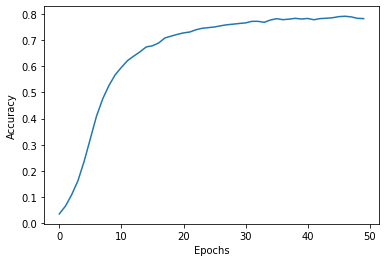

In [17]:
plot_graphs(loaded_history, 'Accuracy')

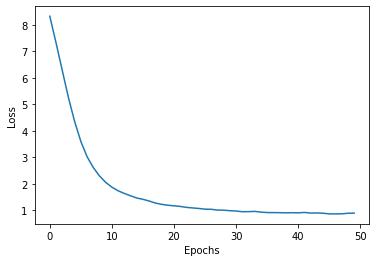

In [18]:
plot_graphs(loaded_history, 'Loss')

In [19]:
def find_word(vocab, index): return list(vocab)[index-1]

def last_string(string):
    tokens = string.split(" ")
    return tokens[len(tokens)-1]

def most_prob_words(predicted, string, vocab, n_words=3):
    sorted_list = predicted.copy()
    sorted_list.sort(reverse=True)
    index_list = [predicted.index(val) for val in sorted_list]
    probable_words = []
    c, i = 0, 0
    while c < n_words and i < len(index_list):
        word = find_word(vocab, index_list[i])
        if word.startswith(string):
            probable_words.append(word)
            c += 1
        i += 1
    return probable_words

In [20]:
seed_text = "الجرأة في الأعمال التج"

string = last_string(seed_text)
vocab = tokenizer.word_index

token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted = loaded_model.predict(token_list, verbose=0)
probable_words = most_prob_words(predicted[0].tolist(), string, vocab, n_words=5)
print(probable_words)

['التجارية', 'التجمع', 'التجربة', 'التجارب', 'التجاري']
